In [ ]:
# Calculate the average trip count per day for each colonia
avg_trip_count_per_colonia_day = cuauhtemoc_data.groupby(['Colonia', 'Week_Day'])['Trip_Duration'].size().reset_index(name='Trip_Count')

avg_trip_count_per_colonia_day = avg_trip_count_per_colonia_day.groupby(['Colonia', 'Week_Day']).mean().reset_index()

# Sort the data to get the top 10 colonias by average trip count
top_10_colonias = avg_trip_count_per_colonia_day.groupby('Colonia')['Trip_Count'].mean().sort_values(ascending=False).head(10).index

filtered_avg_trip_count = avg_trip_count_per_colonia_day[avg_trip_count_per_colonia_day['Colonia'].isin(top_10_colonias)]

# Create a grouped bar plot for the average trip count for top 10 colonias per day of the week
fig = px.bar(filtered_avg_trip_count, 
             x='Week_Day', 
             y='Trip_Count', 
             color='Colonia', 
             barmode='group',
             title='Average Trip Count for Top 10 Colonias per Day of the Week',
             labels={'Week_Day': 'Day of the Week', 'Trip_Count': 'Average Trip Count'},
             height=600, 
             width=1700)

# Customize the layout for better readability
fig.update_layout(
    xaxis_title='Day of the Week',
    yaxis_title='Average Trip Count',
    title_font_size=18,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    legend=dict(
        x=0.85,
        y=1.03,
        bgcolor='rgba(255, 255, 255, 0.5)',  # Background color with some transparency
        bordercolor='Black',
        borderwidth=2
    )
)

# Show the plot
fig.show()

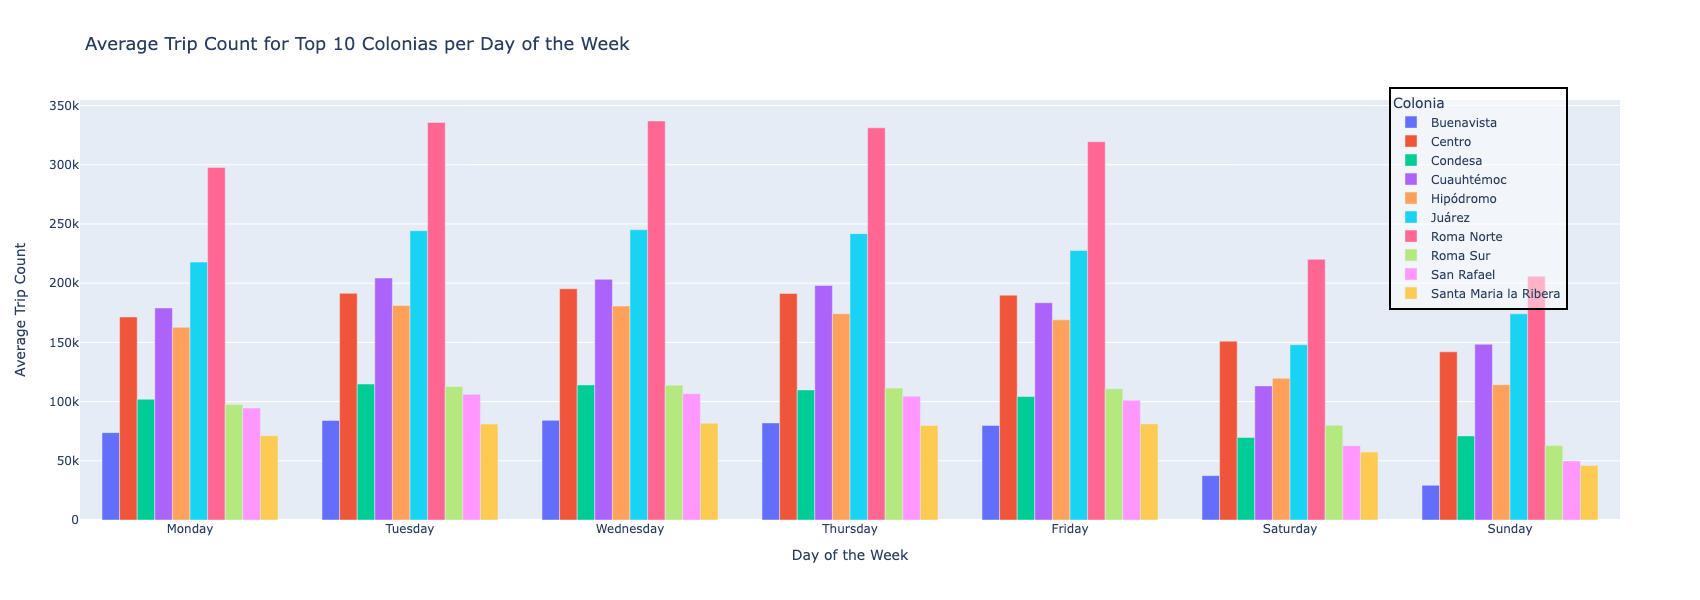

### Roma norte leads trip counts for every day of the week 
### Centro increases in demand on saturdays 
### Overall activity is higher during the middle of the week and slows down over the weekend

In [ ]:
# Calculate the average trip duration per day for each colonia
avg_trip_duration_per_colonia_day = cuauhtemoc_data.groupby(['Colonia', 'Week_Day'])['Trip_Duration'].mean().reset_index(name='Avg_Trip_Duration')

# Sort the data to get the top 10 colonias by average trip duration
top_10_colonias = avg_trip_duration_per_colonia_day.groupby('Colonia')['Avg_Trip_Duration'].mean().sort_values(ascending=False).head(10).index

# Filter the data to include only the top 10 colonias
filtered_avg_trip_duration = avg_trip_duration_per_colonia_day[avg_trip_duration_per_colonia_day['Colonia'].isin(top_10_colonias)]

# Create a grouped bar plot for the average trip duration for top 10 colonias per day of the week
fig = px.bar(filtered_avg_trip_duration, 
             x='Week_Day', 
             y='Avg_Trip_Duration', 
             color='Colonia', 
             barmode='group',
             title='Top 10 Colonias with highest Trip Duration per Day of the Week',
             labels={'Week_Day': 'Day of the Week', 'Avg_Trip_Duration': 'Average Trip Duration (minutes)'},
             height=600, 
             width=1600)

fig.update_layout(
    xaxis_title='Day of the Week',
    yaxis_title='Average Trip Duration (minutes)',
    title_font_size=18,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    legend=dict(
        orientation='h',  # Set legend orientation to horizontal
        yanchor='bottom',
        y=.9,
        xanchor='right',
        x=.8
    )
)

# Show the plot
fig.show()

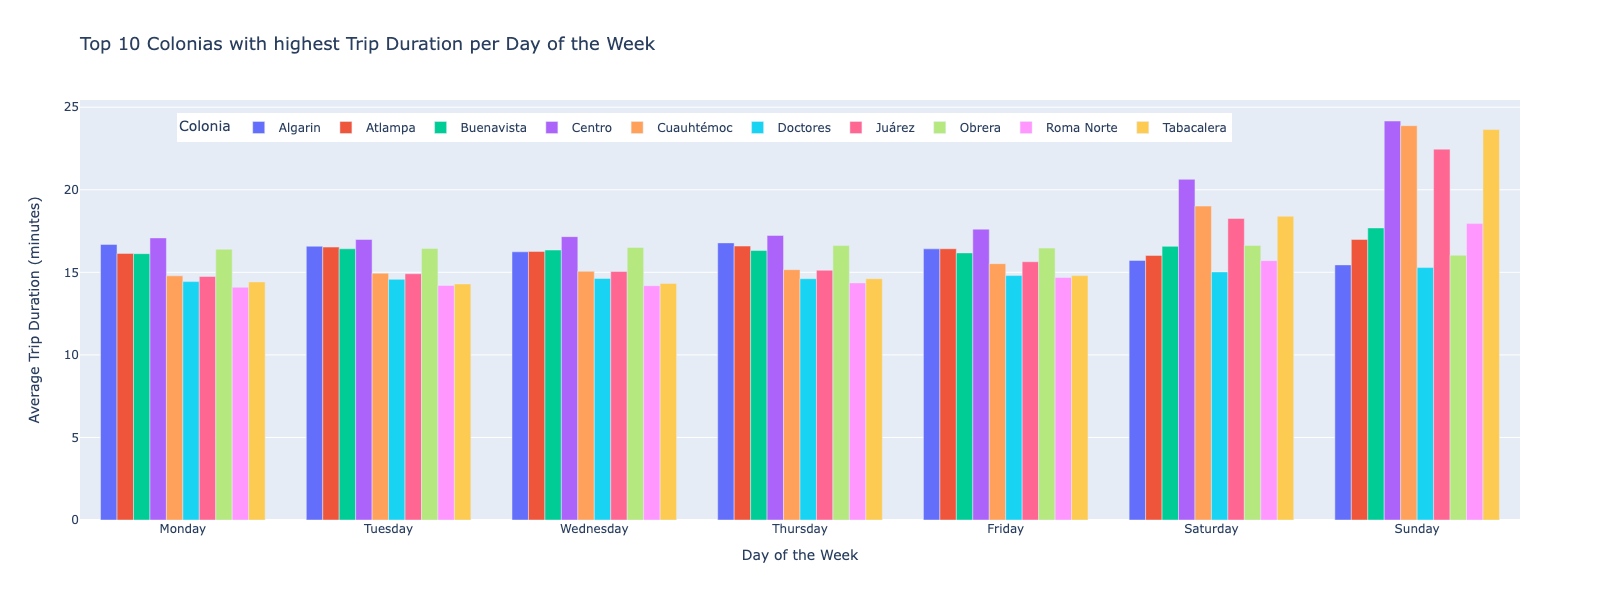

### Weekend activity increases for trip duration especially Centro on Saturdays
### Sundays shows centro, cuauhtemoc, juarez and tabacalera as top colonias for trip duration 

In [ ]:
# Generate a color map for the colonias (only those present in the filtered data)
colonias = filtered_avg_trip_duration['Colonia'].unique()
colors = plt.cm.get_cmap('tab10', len(colonias)).colors  # 'tab20' is a colormap with 20 colors
color_map = {colonia: colors[i % 20] for i, colonia in enumerate(colonias)}
color_map_hex = {colonia: mcolors.rgb2hex(color) for colonia, color in color_map.items()}

# Filter the original data to include only the stations in the top colonias
filtered_data = cuauhtemoc_data[cuauhtemoc_data['Colonia'].isin(colonias)]

# Group by 'Station_ID' and get unique coordinates for each station in top colonias
station_data = filtered_data.groupby(['Station_ID', 'Colonia', 'Latitude', 'Longitude']).size().reset_index(name='Trip_Count').head(20)

# Extract coordinates for all unique stations in Miguel Hidalgo data
coords = cuauhtemoc_data[['Latitude', 'Longitude']].drop_duplicates().values

# Compute the convex hull for all unique stations
hull = ConvexHull(coords)
hull_coords = [coords[vertex].tolist() for vertex in hull.vertices] + [coords[hull.vertices[0]].tolist()]

# Create a Folium map centered at the mean latitude and longitude of the stations
mean_lat_lon = station_data[['Latitude', 'Longitude']].mean()
map_center = [mean_lat_lon['Latitude'], mean_lat_lon['Longitude']]
mymap = folium.Map(location=map_center, zoom_start=14)

# Add a polygon layer for the Miguel Hidalgo boundary
folium.Polygon(
    locations=hull_coords,
    color='blue',
    fill=True,
    fill_opacity=0.2,
    weight=2,
    popup='Miguel Hidalgo Area'
).add_to(mymap)

# Add a marker for each of the stations with color based on Colonia
for idx, row in station_data.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"Station: {row['Station_ID']}<br>Colonia: {row['Colonia']}<br>Trip Count: {row['Trip_Count']}",
        icon=folium.Icon(color='blue', icon_color=color_map_hex[row['Colonia']])
    ).add_to(mymap)

# Add a title to the map
title_html = '''
     <div style="position: fixed; 
     top: 10px; left: 60%; transform: translateX(-50%); width: auto; height: auto; 
     background-color: white; z-index:9999; font-size:22px;
     border:2px solid grey; border-radius: 10px; padding: 5px;">
     <b>Top Stations in Colonias with Highest Average Trip Duration in Cuautehmoc</b>
     </div>
     '''
mymap.get_root().html.add_child(folium.Element(title_html))

# Create a legend for the colonias (only those present in the map)
legend_html = '''
     <div style="position: absolute; 
     top: 60px; left: 50px; width: 390px; height: auto; 
     background-color: white; z-index:9999; font-size:14px;
     border:2px solid grey; border-radius: 10px; padding: 16px;">
     <b>Colonias</b><br>
     <div style="display: grid; grid-template-columns: repeat(5, 1fr); gap: 5px;">
     '''
for colonia in colonias:
    legend_html += f'<div><i style="background:{color_map_hex[colonia]}; width: 15px; height: 15px; display: inline-block;"></i> {colonia}</div>'
legend_html += '</div></div>'

mymap.get_root().html.add_child(folium.Element(legend_html))

# Display the map
mymap

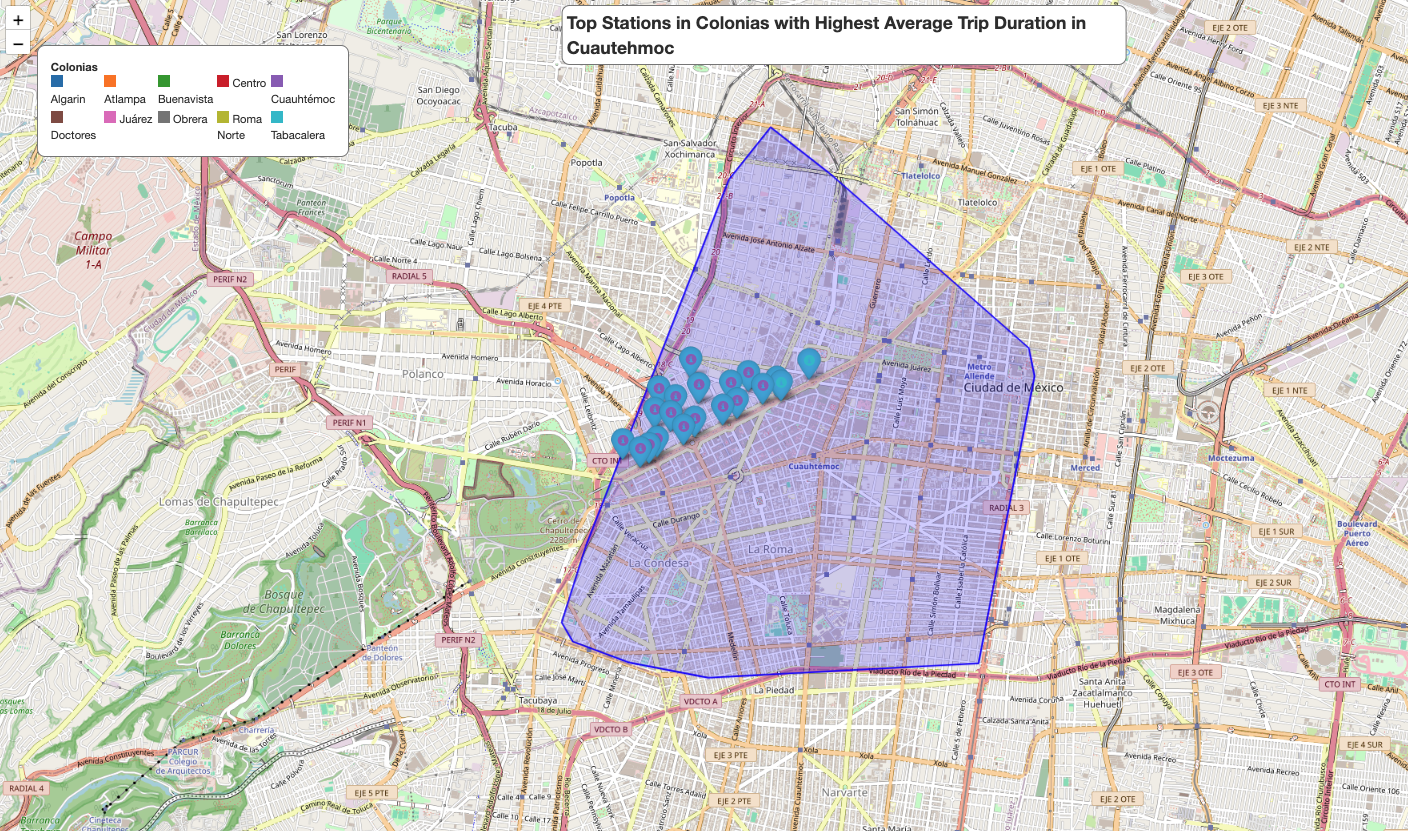

### Stations with the highest trip duration are all clustered on avenida pasea la reforma
### This avenue is very busy and super bike friend
### Most are in colonia Juarez which is a very busy and commercial area with many sky scrappers

In [ ]:
# Calculate the number of trips made by females and males for each colonia
gender_counts = filtered_data.groupby(['Colonia', 'Gender']).size().reset_index(name='Count')

# Calculate the total number of trips for each colonia
total_counts = gender_counts.groupby('Colonia')['Count'].sum().reset_index(name='Total_Count')

# Merge the gender counts with the total counts to calculate percentages
merged_data = pd.merge(gender_counts, total_counts, on='Colonia')
merged_data['Percentage'] = (merged_data['Count'] / merged_data['Total_Count']) * 100

# Define color mapping for age groups
color_map = {
    'F': 'pink',
    'M': 'blue'
}

# Create a stacked bar chart to show the gender distribution as percentages for each colonia
fig = px.bar(merged_data, 
             x='Colonia', 
             y='Percentage', 
             color='Gender', 
             title='Gender Distribution in Top 10 Colonias by Average Trip Duration',
             labels={'Colonia': 'Colonia', 'Percentage': 'Percentage of Trips'},
             height=600, 
             width=1600,
             barmode='group',
             color_discrete_map=color_map)

fig.update_layout(
    xaxis_title='Colonia',
    yaxis_title='Percentage of Trips',
    title_font_size=18,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    legend=dict(
        orientation='h',  # Set legend orientation to horizontal
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    )
)

# Show the plot
fig.show()

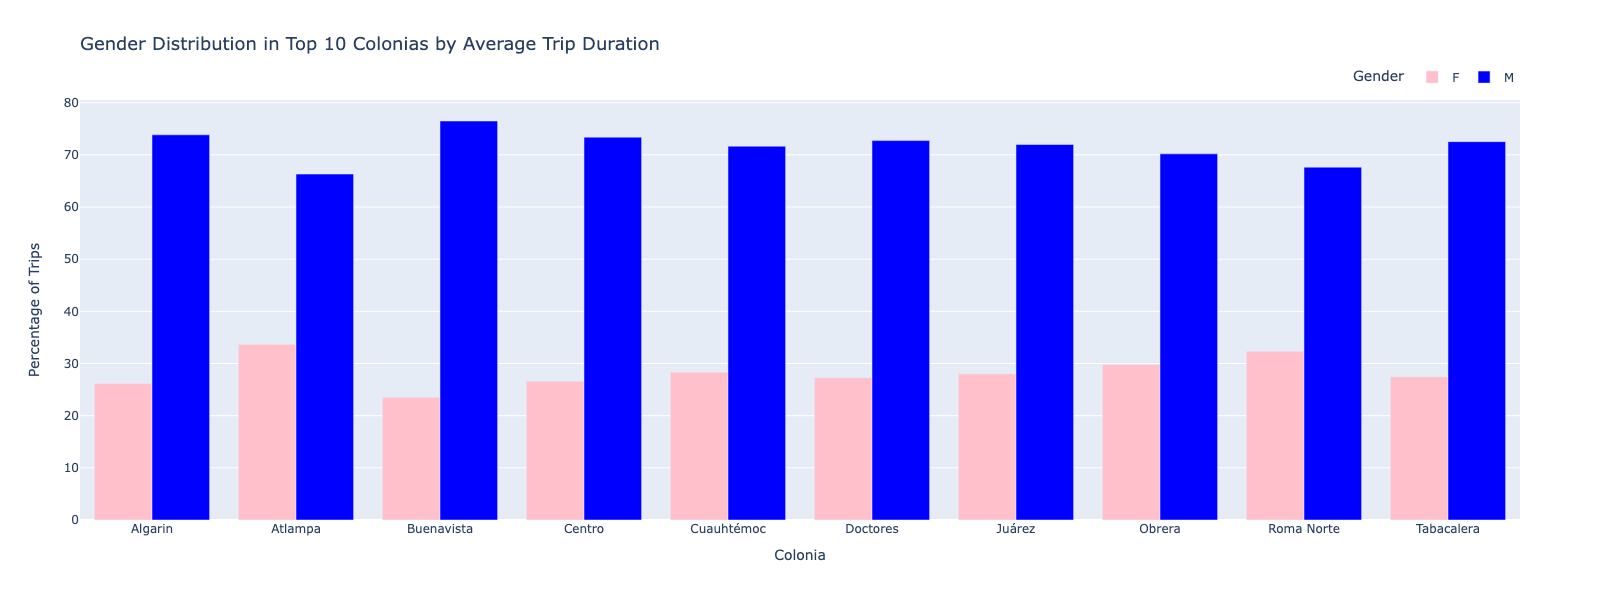

### Atlampa shows the highest percentage of females for avg trip duration with 33.6% and roma norta with 32.5%
### Buena Vista shows the lowest percentage with 23.5% females

In [ ]:
# Calculate the number of trips made by each age group for each colonia
age_group_counts = filtered_data.groupby(['Colonia', 'Age_Group']).size().reset_index(name='Count')

# Calculate the total number of trips for each colonia
total_counts = age_group_counts.groupby('Colonia')['Count'].sum().reset_index(name='Total_Count')

# Merge the age group counts with the total counts to calculate percentages
merged_data = pd.merge(age_group_counts, total_counts, on='Colonia')
merged_data['Percentage'] = (merged_data['Count'] / merged_data['Total_Count']) * 100


# Create a stacked bar chart to show the age group distribution as percentages for each colonia
fig = px.bar(merged_data, 
             x='Colonia', 
             y='Percentage', 
             color='Age_Group', 
             title='Age Group Distribution in Top 10 Colonias by Average Trip Duration',
             labels={'Colonia': 'Colonia', 'Percentage': 'Percentage of Trips'},
             height=600, 
             width=1600,
             barmode='stack',
             color_discrete_map=color_map)

fig.update_layout(
    xaxis_title='Colonia',
    yaxis_title='Percentage of Trips',
    title_font_size=18,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    legend=dict(
        orientation='h',  # Set legend orientation to horizontal
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    )
)

# Show the plot
fig.show()

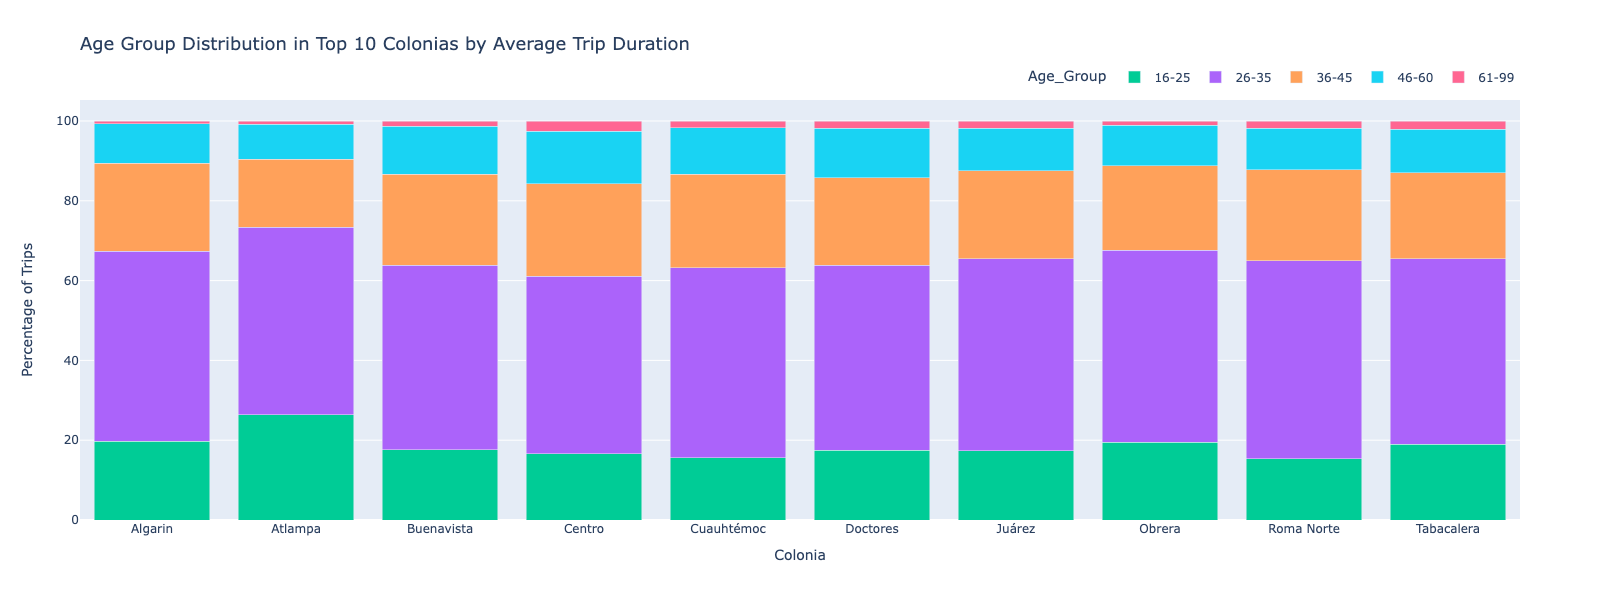

### Age group distribution shows that atlampa has 26.3% for 16-25, which is the highest out of all other colonias 

In [ ]:
# Calculate the average trip duration for each age group per day of the week
avg_trip_duration_per_age_group_day = cuauhtemoc_data.groupby(['Age_Group', 'Week_Day'])['Trip_Duration'].mean().reset_index()

# Create the line chart with Plotly
fig = px.line(avg_trip_duration_per_age_group_day, 
              x='Week_Day', 
              y='Trip_Duration', 
              color='Age_Group', 
              title='Average Trip Duration per Age Group by Day of the Week for Cuautehmoc',
              labels={'Week_Day': 'Day of the Week', 'Trip_Duration': 'Average Trip Duration (minutes)'},
              markers=True,
              height=600, 
              width=1700,
              color_discrete_map=color_map)

fig.update_layout(
    xaxis_title='Day of the Week',
    yaxis_title='Average Trip Duration (minutes)',
    title_font_size=18,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    )
)

# Show the plot
fig.show()

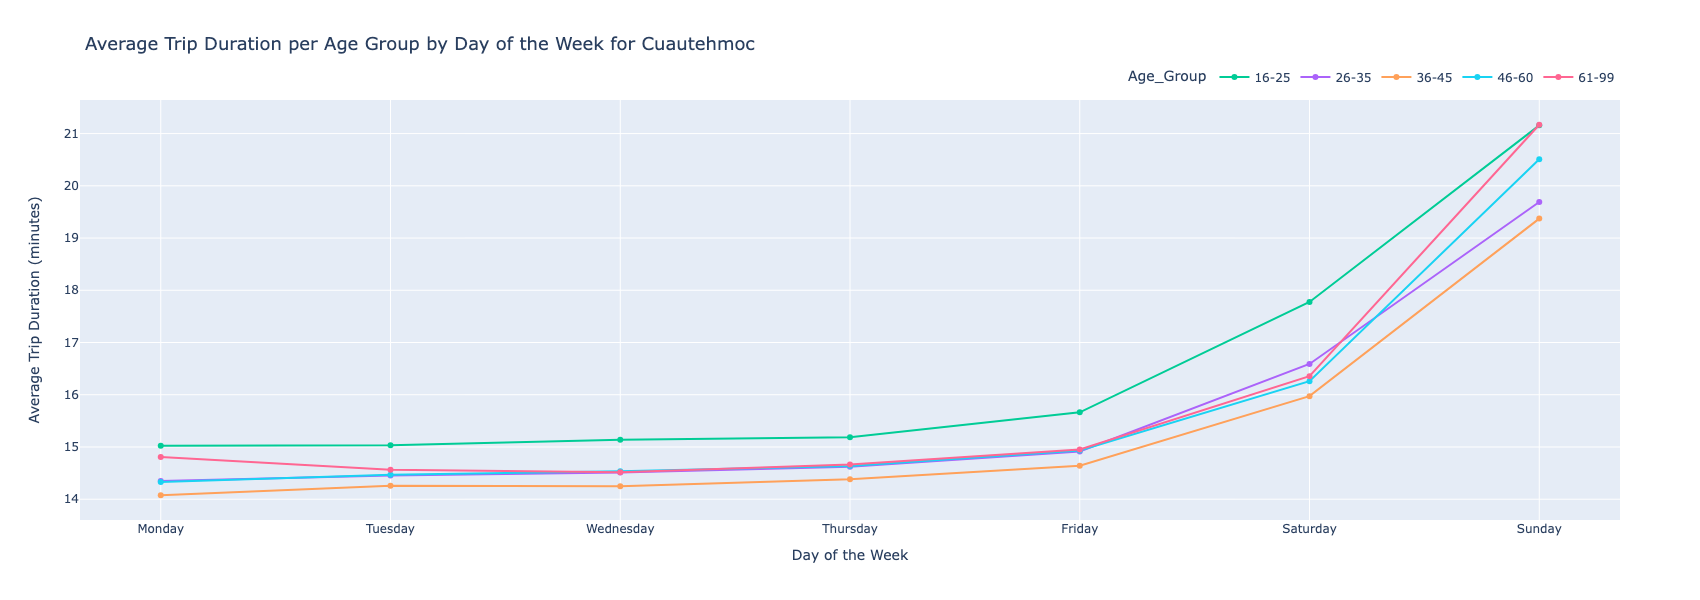

### Averag trip duation per age group for the week shows 16-25 group leading every single day
### 36 - 45 is the lowest for every single day

In [ ]:
# Filter the data for the age group 46-60
age_group_16_25_data = cuauhtemoc_data[cuauhtemoc_data['Age_Group'] == '16-25']

# Calculate the total trips for each colonia per day of the week
total_trips_per_colonia_day = cuauhtemoc_data.groupby(['Colonia', 'Week_Day']).size().reset_index(name='Total_Trips')

# Calculate the trips for the age group 46-60 for each colonia per day of the week
age_group_trips_per_colonia_day = age_group_16_25_data.groupby(['Colonia', 'Week_Day']).size().reset_index(name='Age_Group_Trips')

# Merge the dataframes to get total trips and age group trips together
merged_data = pd.merge(age_group_trips_per_colonia_day, total_trips_per_colonia_day, on=['Colonia', 'Week_Day'])

# Calculate the percentage of trips for the age group 46-60
merged_data['Percentage_Age_Group_16_25'] = (merged_data['Age_Group_Trips'] / merged_data['Total_Trips']) * 100

# Identify the top 10 colonias with the highest percentage for each day
top_10_colonias_per_day = merged_data.groupby('Week_Day').apply(lambda x: x.nlargest(10, 'Percentage_Age_Group_16_25')).reset_index(drop=True)

# Create a bar chart using Plotly
fig = px.bar(top_10_colonias_per_day, 
             x='Week_Day', 
             y='Percentage_Age_Group_16_25', 
             color='Colonia', 
             title='Top 10 Colonias with Highest Percentage of Age Group 16-25 by Day of the Week',
             labels={'Week_Day': 'Day of the Week', 'Percentage_Age_Group_16_25': 'Percentage of Age Group 16-25 (%)'},
             height=600, 
             width=1600,
             barmode='group')

fig.update_layout(
    xaxis_title='Day of the Week',
    yaxis_title='Percentage of Age Group 16-25 (%)',
    title_font_size=18,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    legend=dict(
        orientation='v',
        yanchor='top',
        y=1.02,
        xanchor='left',
        x=1.02
    )
)

# Show the plot
fig.show()

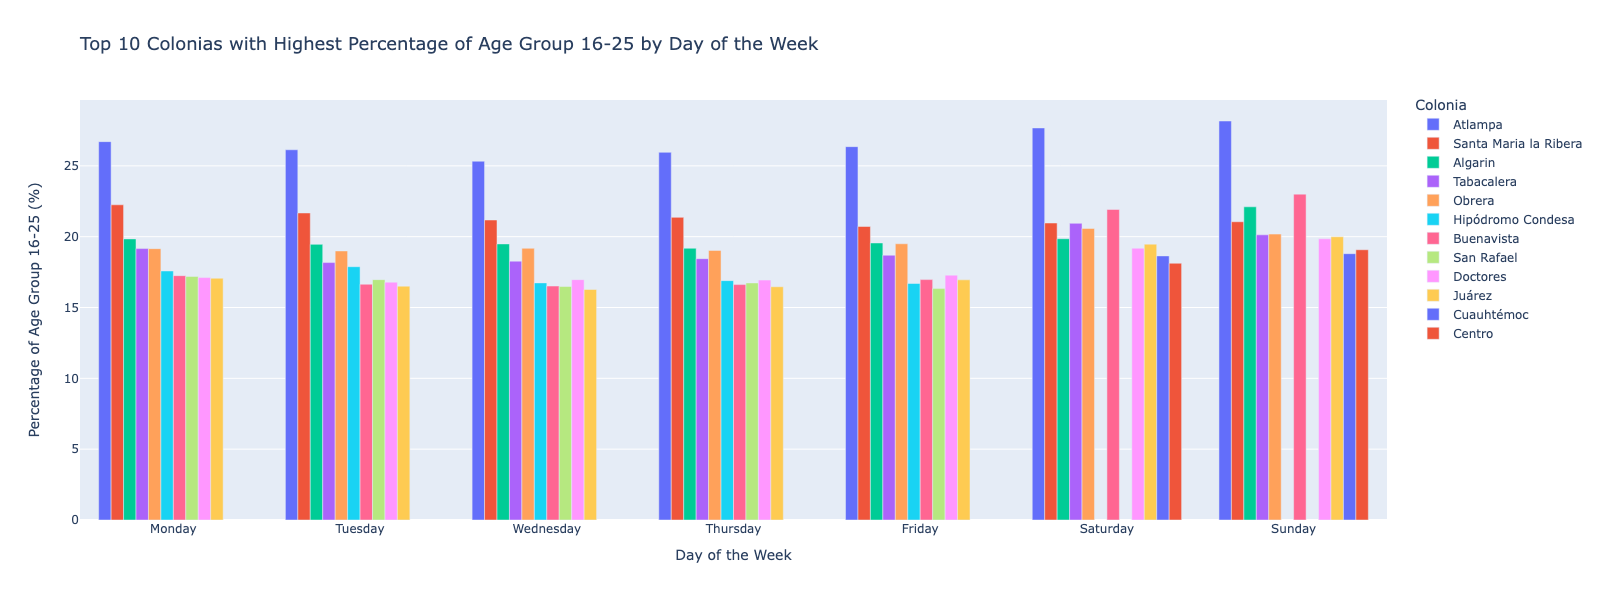

### Atlampa again stands out daily for the highest percentage in age group 16-25 with santa maria la ribera in second 

In [ ]:
# Filter the data for the age group 46-60
age_group_26_35_data = cuauhtemoc_data[cuauhtemoc_data['Age_Group'] == '26-35']

# Calculate the total trips for each colonia per day of the week
total_trips_per_colonia_day = cuauhtemoc_data.groupby(['Colonia', 'Week_Day']).size().reset_index(name='Total_Trips')

# Calculate the trips for the age group 46-60 for each colonia per day of the week
age_group_trips_per_colonia_day = age_group_26_35_data.groupby(['Colonia', 'Week_Day']).size().reset_index(name='Age_Group_Trips')

# Merge the dataframes to get total trips and age group trips together
merged_data = pd.merge(age_group_trips_per_colonia_day, total_trips_per_colonia_day, on=['Colonia', 'Week_Day'])

# Calculate the percentage of trips for the age group 46-60
merged_data['Percentage_Age_Group_26_35'] = (merged_data['Age_Group_Trips'] / merged_data['Total_Trips']) * 100

# Identify the top 10 colonias with the highest percentage for each day
top_10_colonias_per_day = merged_data.groupby('Week_Day').apply(lambda x: x.nlargest(10, 'Percentage_Age_Group_26_35')).reset_index(drop=True)

# Create a bar chart using Plotly
fig = px.bar(top_10_colonias_per_day, 
             x='Week_Day', 
             y='Percentage_Age_Group_26_35', 
             color='Colonia', 
             title='Top 10 Colonias with Highest Percentage of Age Group 26-35 by Day of the Week',
             labels={'Week_Day': 'Day of the Week', 'Percentage_Age_Group_26_35': 'Percentage of Age Group 26-35 (%)'},
             height=600, 
             width=1600,
             barmode='group')

fig.update_layout(
    xaxis_title='Day of the Week',
    yaxis_title='Percentage of Age Group 26-35 (%)',
    title_font_size=18,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    legend=dict(
        orientation='v',
        yanchor='top',
        y=1.02,
        xanchor='left',
        x=1.02
    )
)

# Show the plot
fig.show()

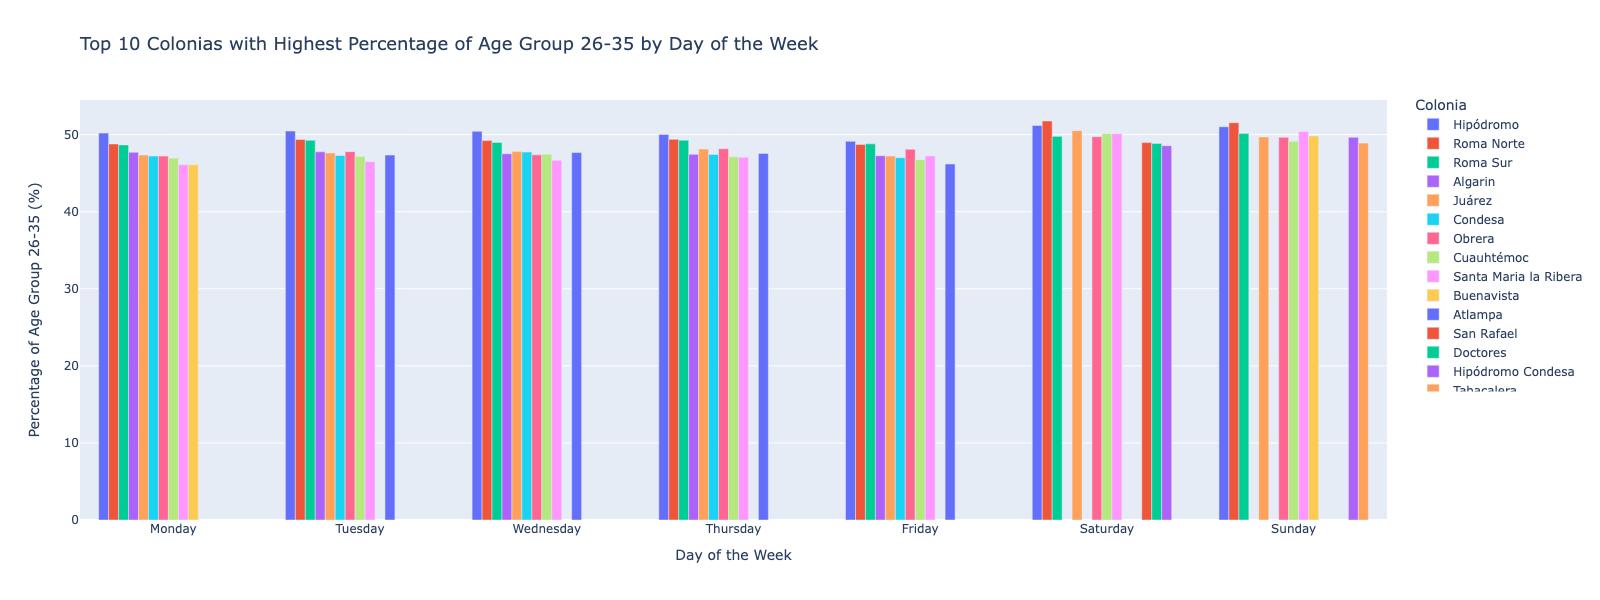

### 26-35 age group percentage is led by hipodromo for most days with roma norte for the weekend 

In [ ]:
# Filter the data for the age group 46-60
age_group_36_45_data = cuauhtemoc_data[cuauhtemoc_data['Age_Group'] == '36-45']

# Calculate the total trips for each colonia per day of the week
total_trips_per_colonia_day = cuauhtemoc_data.groupby(['Colonia', 'Week_Day']).size().reset_index(name='Total_Trips')

# Calculate the trips for the age group 46-60 for each colonia per day of the week
age_group_trips_per_colonia_day = age_group_36_45_data.groupby(['Colonia', 'Week_Day']).size().reset_index(name='Age_Group_Trips')

# Merge the dataframes to get total trips and age group trips together
merged_data = pd.merge(age_group_trips_per_colonia_day, total_trips_per_colonia_day, on=['Colonia', 'Week_Day'])

# Calculate the percentage of trips for the age group 46-60
merged_data['Percentage_Age_Group_36_45'] = (merged_data['Age_Group_Trips'] / merged_data['Total_Trips']) * 100

# Identify the top 10 colonias with the highest percentage for each day
top_10_colonias_per_day = merged_data.groupby('Week_Day').apply(lambda x: x.nlargest(10, 'Percentage_Age_Group_36_45')).reset_index(drop=True)

# Create a bar chart using Plotly
fig = px.bar(top_10_colonias_per_day, 
             x='Week_Day', 
             y='Percentage_Age_Group_36_45', 
             color='Colonia', 
             title='Top 10 Colonias with Highest Percentage of Age Group 36-45 by Day of the Week',
             labels={'Week_Day': 'Day of the Week', 'Percentage_Age_Group_36_45': 'Percentage of Age Group 36-45 (%)'},
             height=600, 
             width=1600,
             barmode='group')

fig.update_layout(
    xaxis_title='Day of the Week',
    yaxis_title='Percentage of Age Group 36-45 (%)',
    title_font_size=18,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    legend=dict(
        orientation='v',
        yanchor='top',
        y=1.02,
        xanchor='left',
        x=1.02
    )
)

# Show the plot
fig.show()

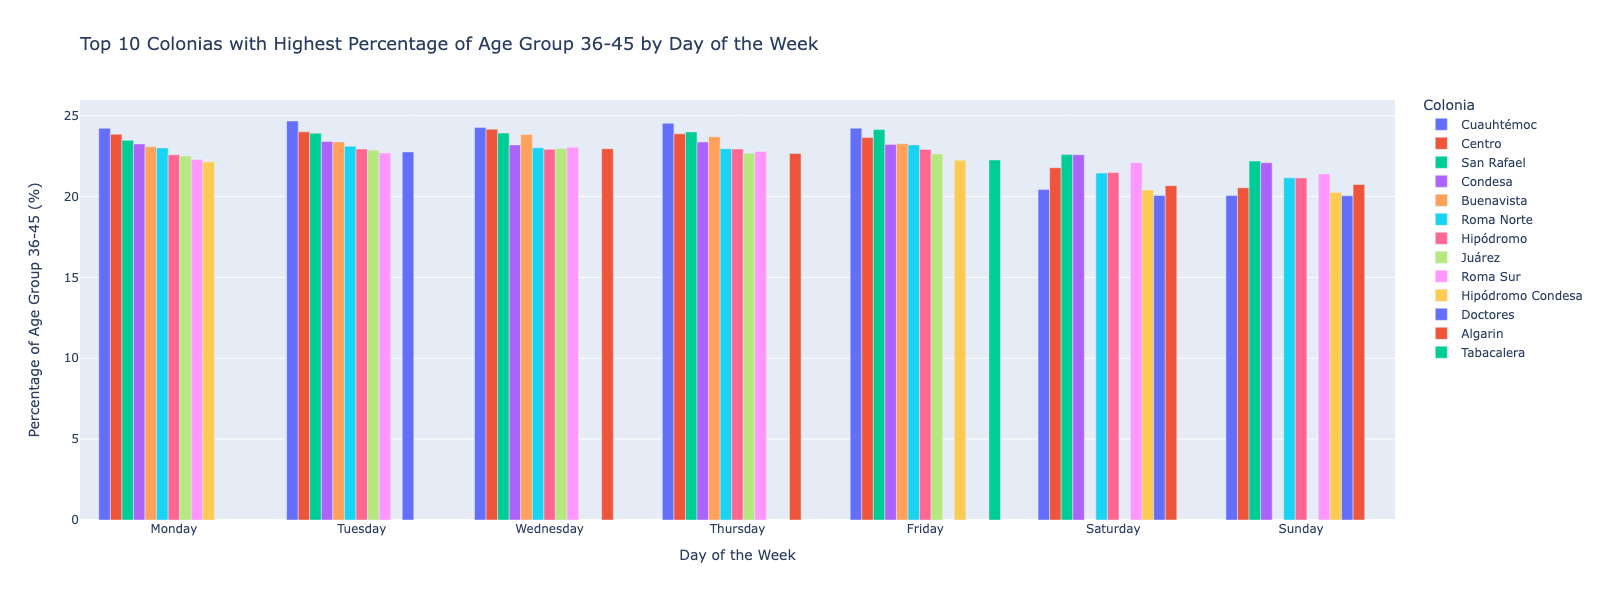

### age group 36-45 percentage is led daily with by cuauhtémoc with the weekend close with san rafael, condesa and roma sur

In [ ]:
# Filter the data for the age group 46-60
age_group_46_60_data = cuauhtemoc_data[cuauhtemoc_data['Age_Group'] == '46-60']

# Calculate the total trips for each colonia per day of the week
total_trips_per_colonia_day = cuauhtemoc_data.groupby(['Colonia', 'Week_Day']).size().reset_index(name='Total_Trips')

# Calculate the trips for the age group 46-60 for each colonia per day of the week
age_group_trips_per_colonia_day = age_group_46_60_data.groupby(['Colonia', 'Week_Day']).size().reset_index(name='Age_Group_Trips')

# Merge the dataframes to get total trips and age group trips together
merged_data = pd.merge(age_group_trips_per_colonia_day, total_trips_per_colonia_day, on=['Colonia', 'Week_Day'])

# Calculate the percentage of trips for the age group 46-60
merged_data['Percentage_Age_Group_46_60'] = (merged_data['Age_Group_Trips'] / merged_data['Total_Trips']) * 100

# Identify the top 10 colonias with the highest percentage for each day
top_10_colonias_per_day = merged_data.groupby('Week_Day').apply(lambda x: x.nlargest(10, 'Percentage_Age_Group_46_60')).reset_index(drop=True)

# Create a bar chart using Plotly
fig = px.bar(top_10_colonias_per_day, 
             x='Week_Day', 
             y='Percentage_Age_Group_46_60', 
             color='Colonia', 
             title='Top 10 Colonias with Highest Percentage of Age Group 46-60 by Day of the Week',
             labels={'Week_Day': 'Day of the Week', 'Percentage_Age_Group_46_60': 'Percentage of Age Group 46-60 (%)'},
             height=600, 
             width=1600,
             barmode='group')

fig.update_layout(
    xaxis_title='Day of the Week',
    yaxis_title='Percentage of Age Group 46-60 (%)',
    title_font_size=18,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    legend=dict(
        orientation='v',
        yanchor='top',
        y=1.02,
        xanchor='left',
        x=1.02
    )
)

# Show the plot
fig.show()

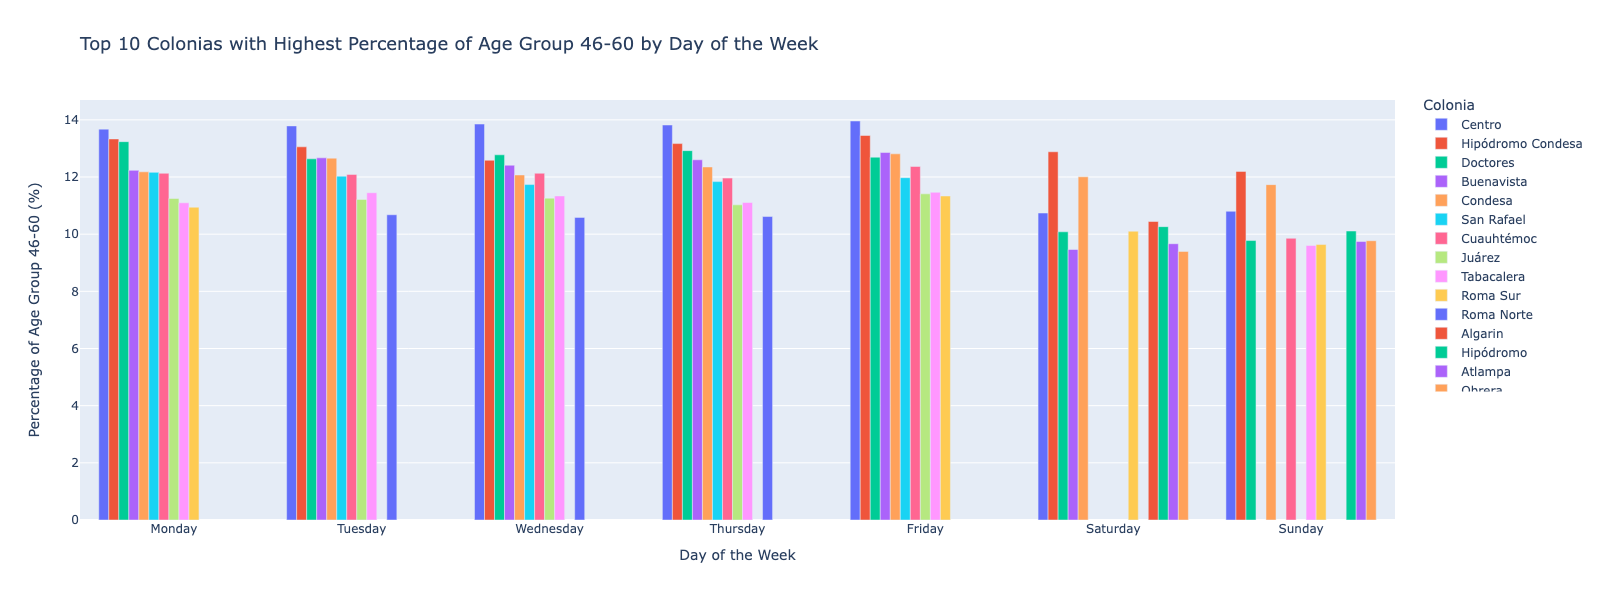

### Centro has the highest percentage for age group 46-60 for week day and weekend is hipodromo and condesa

In [ ]:
# Filter the data for the age group 46-60
age_group_61_99_data = cuauhtemoc_data[cuauhtemoc_data['Age_Group'] == '61-99']

# Calculate the total trips for each colonia per day of the week
total_trips_per_colonia_day = cuauhtemoc_data.groupby(['Colonia', 'Week_Day']).size().reset_index(name='Total_Trips')

# Calculate the trips for the age group 46-60 for each colonia per day of the week
age_group_trips_per_colonia_day = age_group_61_99_data.groupby(['Colonia', 'Week_Day']).size().reset_index(name='Age_Group_Trips')

# Merge the dataframes to get total trips and age group trips together
merged_data = pd.merge(age_group_trips_per_colonia_day, total_trips_per_colonia_day, on=['Colonia', 'Week_Day'])

# Calculate the percentage of trips for the age group 46-60
merged_data['Percentage_Age_Group_61_99'] = (merged_data['Age_Group_Trips'] / merged_data['Total_Trips']) * 100

# Identify the top 10 colonias with the highest percentage for each day
top_10_colonias_per_day = merged_data.groupby('Week_Day').apply(lambda x: x.nlargest(10, 'Percentage_Age_Group_61_99')).reset_index(drop=True)

# Create a bar chart using Plotly
fig = px.bar(top_10_colonias_per_day, 
             x='Week_Day', 
             y='Percentage_Age_Group_61_99', 
             color='Colonia', 
             title='Top 10 Colonias with Highest Percentage of Age Group 61-99 by Day of the Week',
             labels={'Week_Day': 'Day of the Week', 'Percentage_Age_Group_61_99': 'Percentage of Age Group 61-99 (%)'},
             height=600, 
             width=1600,
             barmode='group')

fig.update_layout(
    xaxis_title='Day of the Week',
    yaxis_title='Percentage of Age Group 61-99 (%)',
    title_font_size=18,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    legend=dict(
        orientation='v',
        yanchor='top',
        y=1.02,
        xanchor='left',
        x=1.02
    )
)

# Show the plot
fig.show()

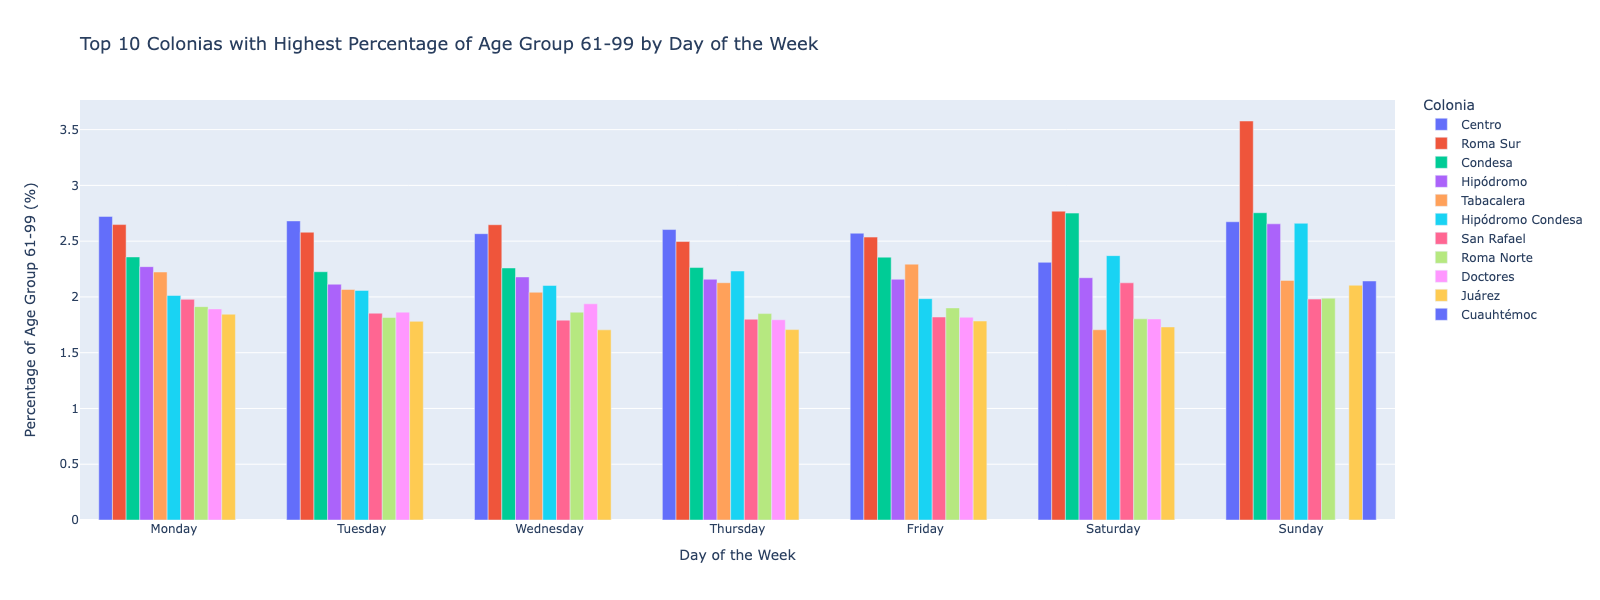

### Age group 61-99 shows roma sur standing out  with the highest percentage out of all other colonias and days 
### Week day shows centro as the top colonia with highest percetnage for age group 61-99 with roma sur in second

In [ ]:
# Group by 'Hour' and 'Colonia' and count the number of trips
trip_count_per_hour_colonia = cuauhtemoc_data.groupby(['Hour', 'Colonia']).size().reset_index(name='Trip_Count')

# Get the top 10 colonias for each hour by trip count
top_10_colonias_per_hour = trip_count_per_hour_colonia.groupby('Hour').apply(lambda x: x.nlargest(10, 'Trip_Count')).reset_index(drop=True)

# Create a bar chart
fig = px.bar(top_10_colonias_per_hour, x='Hour', y='Trip_Count', color='Colonia', barmode='group',
             title='Top 10 Colonias by Number of Trips per Hour in Cuautehmoc',
             labels={'Hour': 'Hour of the Day', 'Trip_Count': 'Number of Trips', 'Colonia': 'Colonia'})

# Customize the layout for better readability
fig.update_layout(
    xaxis_title='Hour of the Day',
    yaxis_title='Number of Trips',
    xaxis_tickangle=-45,
    title_font_size=18,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    height=600  # Set the height of the chart
)

# Update x-axis ticks to show all hours from 0 to 23
fig.update_xaxes(tickmode='array', tickvals=list(range(24)))

# Show the plot
fig.show()

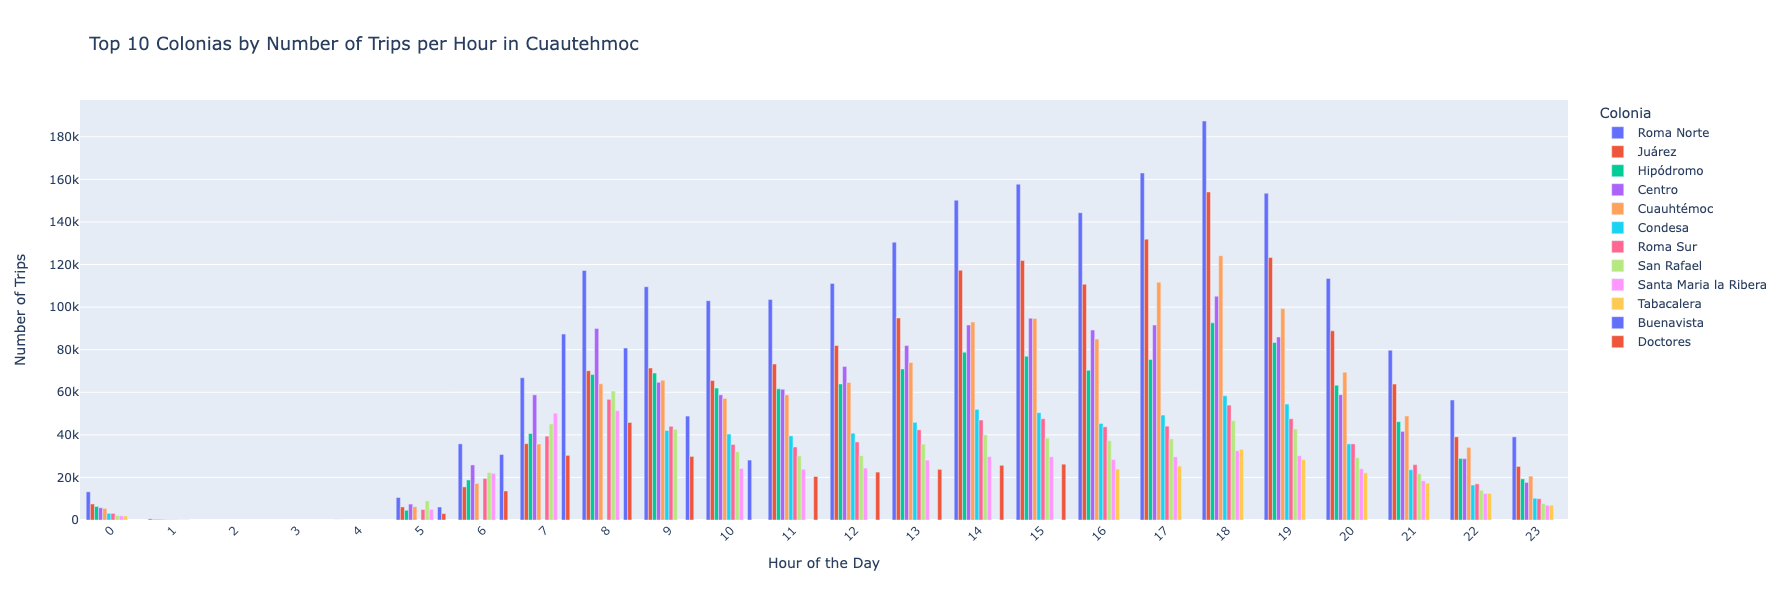

### Hourly data show roma norte leads every single hour in trips with centro second in popularity in the morning rush hours and juarez after 9am

In [ ]:
# Extract the unique colonias from the top 10 lists
top_colonias = top_10_colonias_per_hour['Colonia'].unique()

# Filter the original data to include only the top colonias
filtered_data = cuauhtemoc_data[cuauhtemoc_data['Colonia'].isin(top_colonias)]

# Group by 'Station_ID' and get unique coordinates for each station in top colonias
station_data = filtered_data.groupby(['Station_ID', 'Colonia', 'Latitude', 'Longitude']).size().reset_index(name='Trip_Count').head(20)

# Create a Folium map centered at the mean latitude and longitude of the stations
mean_lat_lon = station_data[['Latitude', 'Longitude']].mean()
map_center = [mean_lat_lon['Latitude'], mean_lat_lon['Longitude']]
mymap = folium.Map(location=map_center, zoom_start=14)

# Add a marker for each of the stations with color based on Colonia
colors = plt.cm.get_cmap('tab20', len(top_colonias)).colors
color_map = {colonia: mcolors.rgb2hex(colors[i % len(colors)]) for i, colonia in enumerate(top_colonias)}

for idx, row in station_data.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"Station: {row['Station_ID']}<br>Colonia: {row['Colonia']}<br>Trip Count: {row['Trip_Count']}",
        icon=folium.Icon(color='blue', icon_color=color_map[row['Colonia']])
    ).add_to(mymap)

# Add a title to the map
title_html = '''
     <div style="position: fixed; 
     top: 10px; left: 60%; transform: translateX(-50%); width: auto; height: auto; 
     background-color: white; z-index:9999; font-size:22px;
     border:2px solid grey; border-radius: 10px; padding: 5px;">
     <b>Top Stations in Colonias with Highest Trip Counts hourly in Cuautehmoc</b>
     </div>
     '''
mymap.get_root().html.add_child(folium.Element(title_html))

# Create a legend for the colonias (only those present in the map)
legend_html = '''
     <div style="position: absolute; 
     top: 60px; left: 50px; width: 390px; height: auto; 
     background-color: white; z-index:9999; font-size:14px;
     border:2px solid grey; border-radius: 10px; padding: 16px;">
     <b>Colonias</b><br>
     <div style="display: grid; grid-template-columns: repeat(5, 1fr); gap: 5px;">
     '''
for colonia in top_colonias:
    legend_html += f'<div><i style="background:{color_map[colonia]}; width: 15px; height: 15px; display: inline-block;"></i> {colonia}</div>'
legend_html += '</div></div>'

mymap.get_root().html.add_child(folium.Element(legend_html))

# Display the map
mymap

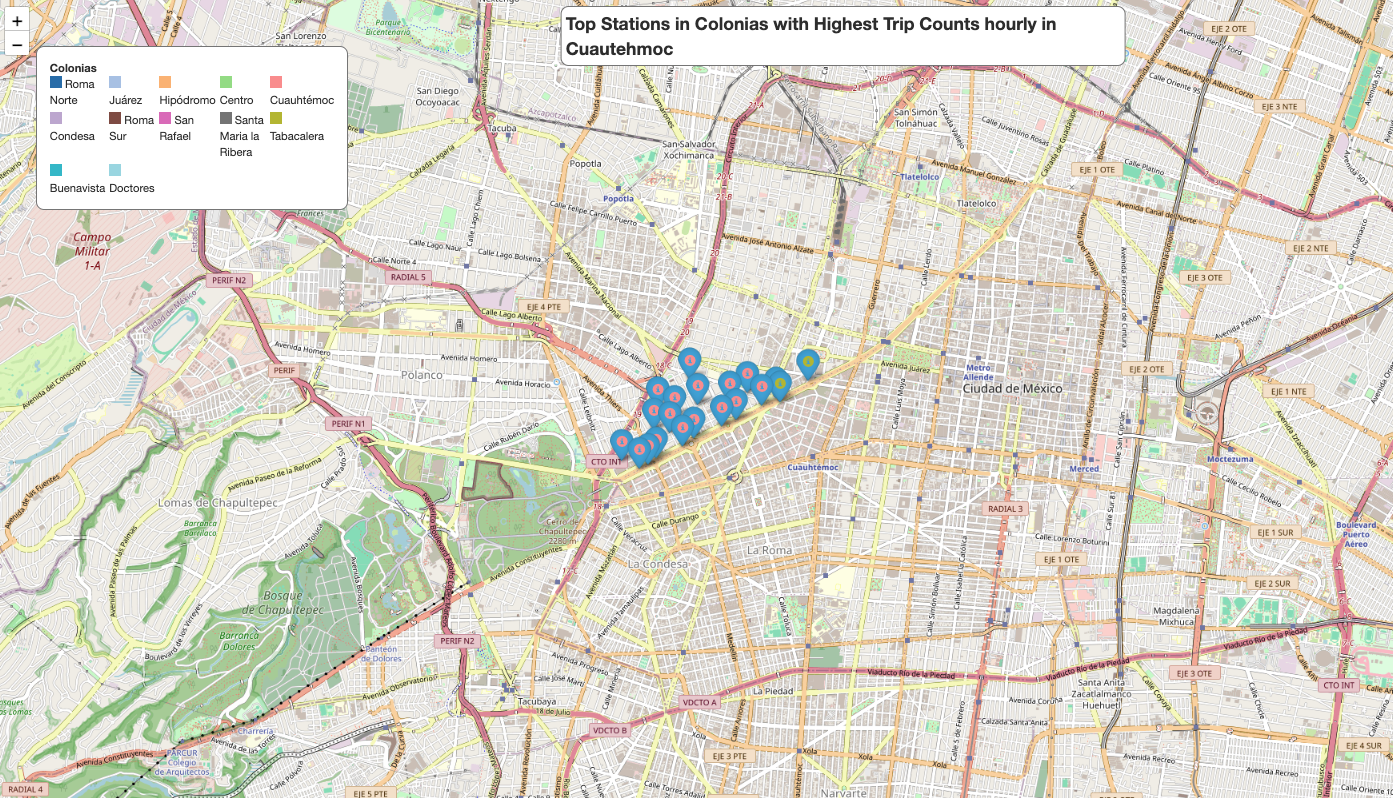

### Hourly data again shows that the stations with highest trip durations are found on avenida paseo la reforma

In [ ]:
# Filter the data to include only female users
female_data = cuauhtemoc_data[cuauhtemoc_data['Gender'] == 'F']

# Group by 'Hour' and 'Colonia' and count the number of trips
trip_count_per_hour_colonia_female = female_data.groupby(['Hour', 'Colonia']).size().reset_index(name='Trip_Count')

# Get the top 3 colonias for each hour by trip count
top_3_colonias_per_hour = trip_count_per_hour_colonia_female.groupby('Hour').apply(lambda x: x.nlargest(3, 'Trip_Count')).reset_index(drop=True)

# Create a bar chart to visualize the number of trips by hour and colonia
fig = px.bar(top_3_colonias_per_hour, x='Hour', y='Trip_Count', color='Colonia', barmode='group',
             title='Top 3 Colonias with the Highest Number of Female Users per Hour in Cuautehmoc',
             labels={'Hour': 'Hour of the Day', 'Trip_Count': 'Number of Trips', 'Colonia': 'Colonia'})

# Customize the layout for better readability
fig.update_layout(
    xaxis_title='Hour of the Day',
    yaxis_title='Number of Trips',
    xaxis_tickangle=-45,
    title_font_size=18,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    height=600  # Set the height of the chart
)

# Update x-axis ticks to show all hours from 0 to 23
fig.update_xaxes(tickmode='array', tickvals=list(range(24)))

# Show the plot
fig.show()

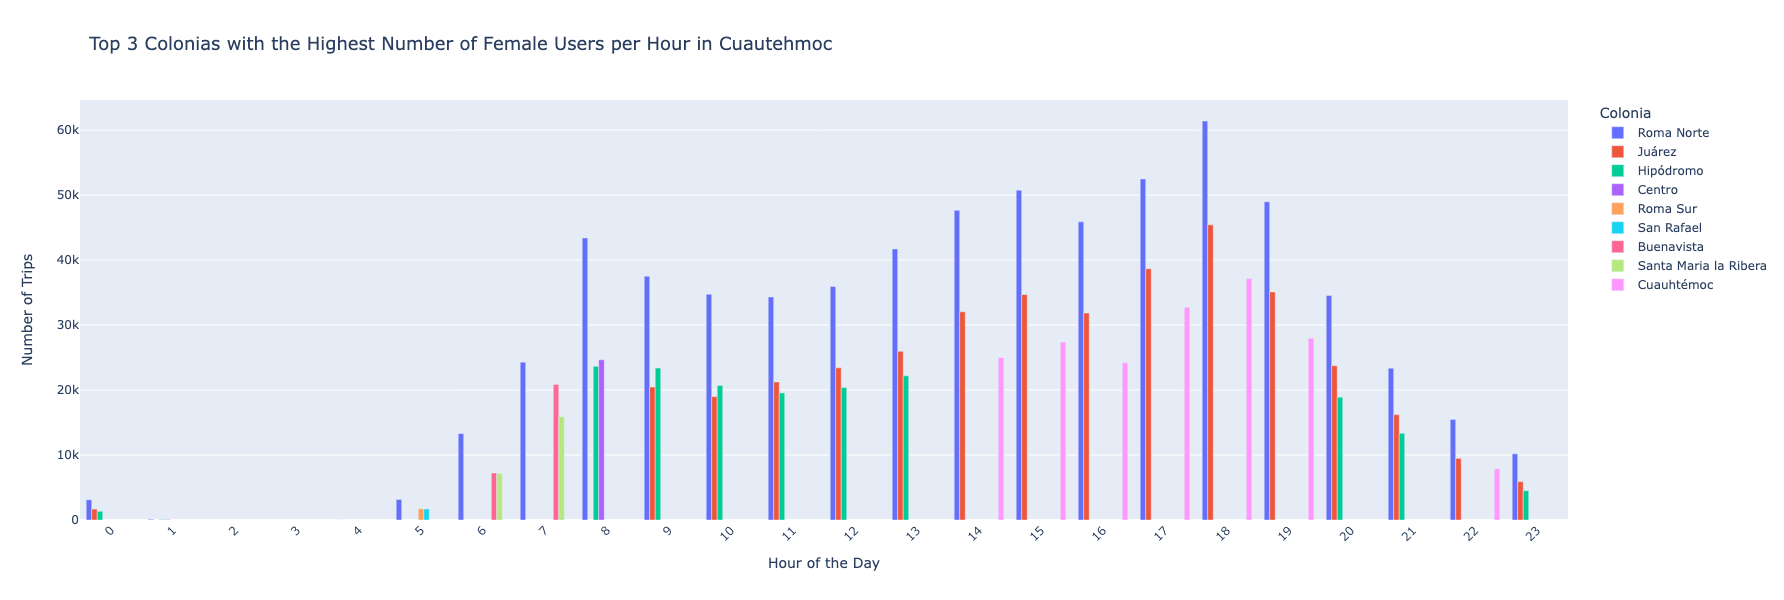

### Top colonias for females by the hour ais Roma Norte
### 8am shows a spike in centro
### 9-13 show juarez and hipodromo
### 14-18 show juarez and cuauhtemoc
### 20-21 shows hipodromo

In [ ]:
# Group by 'Hour' and 'Colonia' and calculate the average trip duration
avg_trip_duration_per_hour_colonia_female = female_data.groupby(['Hour', 'Colonia'])['Trip_Duration'].mean().reset_index(name='Avg_Trip_Duration')

# Get the colonia with the highest average trip duration for each hour
max_female_avg_trip_duration_per_hour = avg_trip_duration_per_hour_colonia_female.loc[avg_trip_duration_per_hour_colonia_female.groupby('Hour')['Avg_Trip_Duration'].idxmax()]

# Create a bar chart to visualize the average trip duration by hour and colonia
fig = px.bar(max_female_avg_trip_duration_per_hour, x='Hour', y='Avg_Trip_Duration', color='Colonia', barmode='group',
             title='Colonias with the Highest Average Trip Duration for Female Users per Hour in Cuautehmoc',
             labels={'Hour': 'Hour of the Day', 'Avg_Trip_Duration': 'Average Trip Duration (minutes)', 'Colonia': 'Colonia'})

# Customize the layout for better readability
fig.update_layout(
    xaxis_title='Hour of the Day',
    yaxis_title='Average Trip Duration (minutes)',
    xaxis_tickangle=-45,
    title_font_size=18,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    height=600 # Set the height of the chart
)

# Update x-axis ticks to show all hours from 0 to 23
fig.update_xaxes(tickmode='array', tickvals=list(range(24)))

# Show the plot
fig.show()

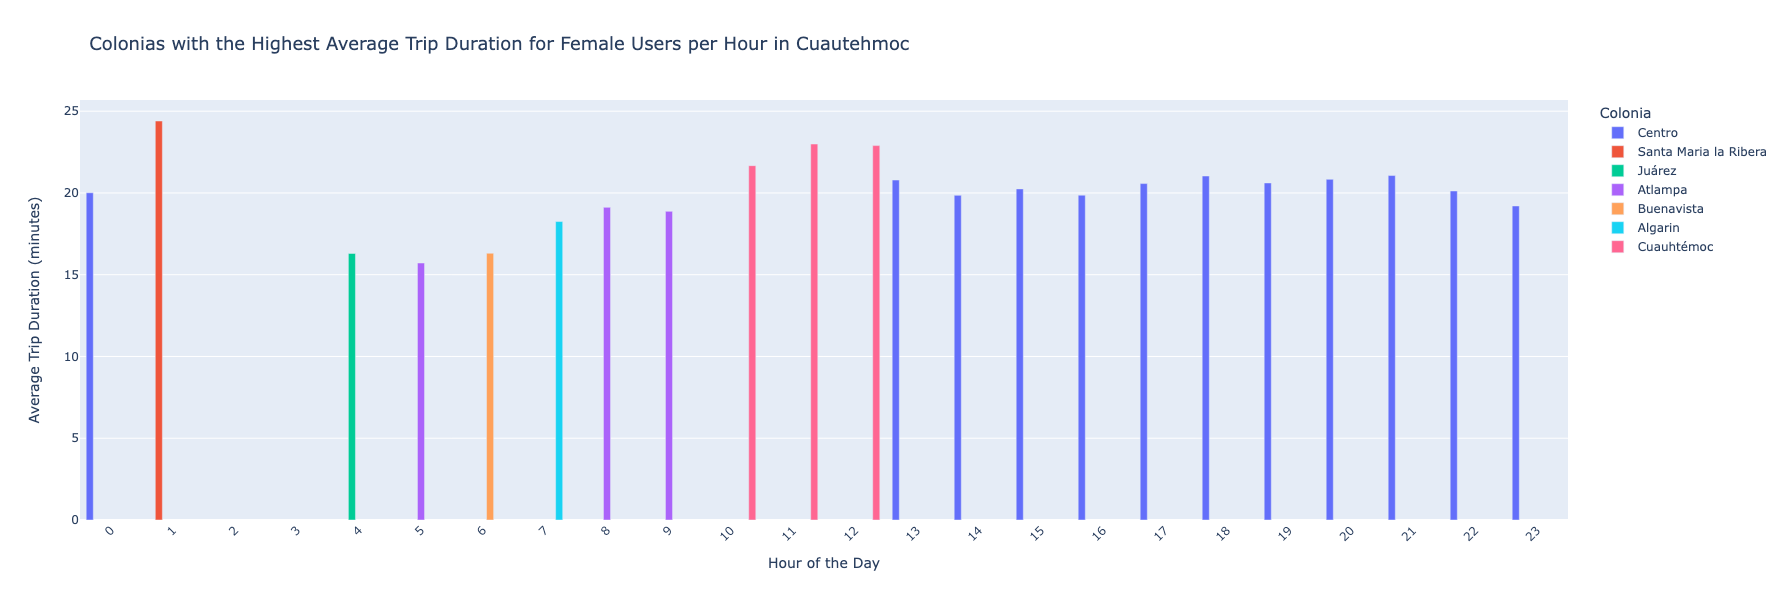

### Females avg trip duration shows that centro is the most popular from 13:00-23:00 hours
### 10-12pm shows santa maria la ribera 
### 8-9am is atlampa 

In [ ]:
# Group by 'Hour' and 'Colonia' and count the number of trips
trip_count_per_hour_colonia_age_group = age_group_16_25_data.groupby(['Hour', 'Colonia']).size().reset_index(name='Trip_Count')

# Get the top 3 colonias for each hour by trip count
top_3_colonias_per_hour_age_group = trip_count_per_hour_colonia_age_group.groupby('Hour').apply(lambda x: x.nlargest(3, 'Trip_Count')).reset_index(drop=True)

# Create a bar chart using Plotly
fig = px.bar(top_3_colonias_per_hour_age_group, 
             x='Hour', 
             y='Trip_Count', 
             color='Colonia', 
             title='Top 3 Colonias with the Most Trips Taken by Users (Age 16-25) per Hour in Cuauhtemoc',
             labels={'Hour': 'Hour of the Day', 'Trip_Count': 'Number of Trips', 'Colonia': 'Colonia'},
             barmode='group')

# Customize the layout for better readability
fig.update_layout(
    xaxis_title='Hour of the Day',
    yaxis_title='Number of Trips',
    xaxis_tickangle=-45,
    title_font_size=18,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    height=600,  # Set the height of the chart
    bargap=0.15,  # Adjust the gap between bars for better visualization
    bargroupgap=0.1  # Adjust the gap between groups of bars
)

# Update x-axis ticks to show all hours from 0 to 23
fig.update_xaxes(tickmode='array', tickvals=list(range(24)))

# Show the plot
fig.show()

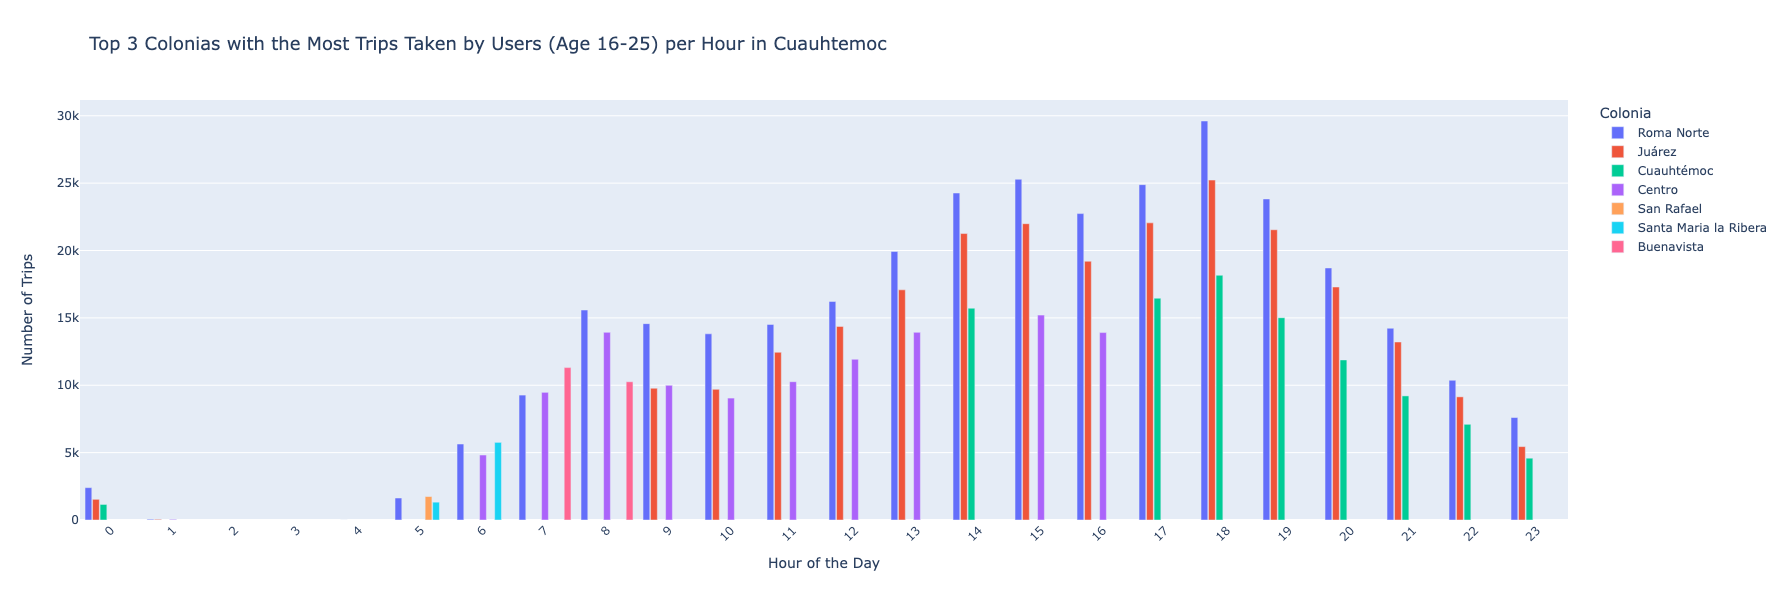

### Roma norte overall is the most popular for age group 16-25 across all hours
### Peaks start at 8am, 3pm and 6pm
### Juarez shows high usage after roma starting at 9am until 1pm
### At 5pm cuauhtemoc shows activity until 11pm

In [ ]:
# Group by 'Hour' and 'Colonia' and count the number of trips
trip_count_per_hour_colonia_age_group = age_group_26_35_data.groupby(['Hour', 'Colonia']).size().reset_index(name='Trip_Count')

# Get the top 3 colonias for each hour by trip count
top_3_colonias_per_hour_age_group = trip_count_per_hour_colonia_age_group.groupby('Hour').apply(lambda x: x.nlargest(3, 'Trip_Count')).reset_index(drop=True)

# Create a bar chart using Plotly
fig = px.bar(top_3_colonias_per_hour_age_group, 
             x='Hour', 
             y='Trip_Count', 
             color='Colonia', 
             title='Top 3 Colonias with the Most Trips Taken by Users (Age 26-35 ) per Hour in Cuauhtemoc',
             labels={'Hour': 'Hour of the Day', 'Trip_Count': 'Number of Trips', 'Colonia': 'Colonia'},
             barmode='group')

# Customize the layout for better readability
fig.update_layout(
    xaxis_title='Hour of the Day',
    yaxis_title='Number of Trips',
    xaxis_tickangle=-45,
    title_font_size=18,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    height=600,  # Set the height of the chart
    bargap=0.15,  # Adjust the gap between bars for better visualization
    bargroupgap=0.1  # Adjust the gap between groups of bars
)

# Update x-axis ticks to show all hours from 0 to 23
fig.update_xaxes(tickmode='array', tickvals=list(range(24)))

# Show the plot
fig.show()

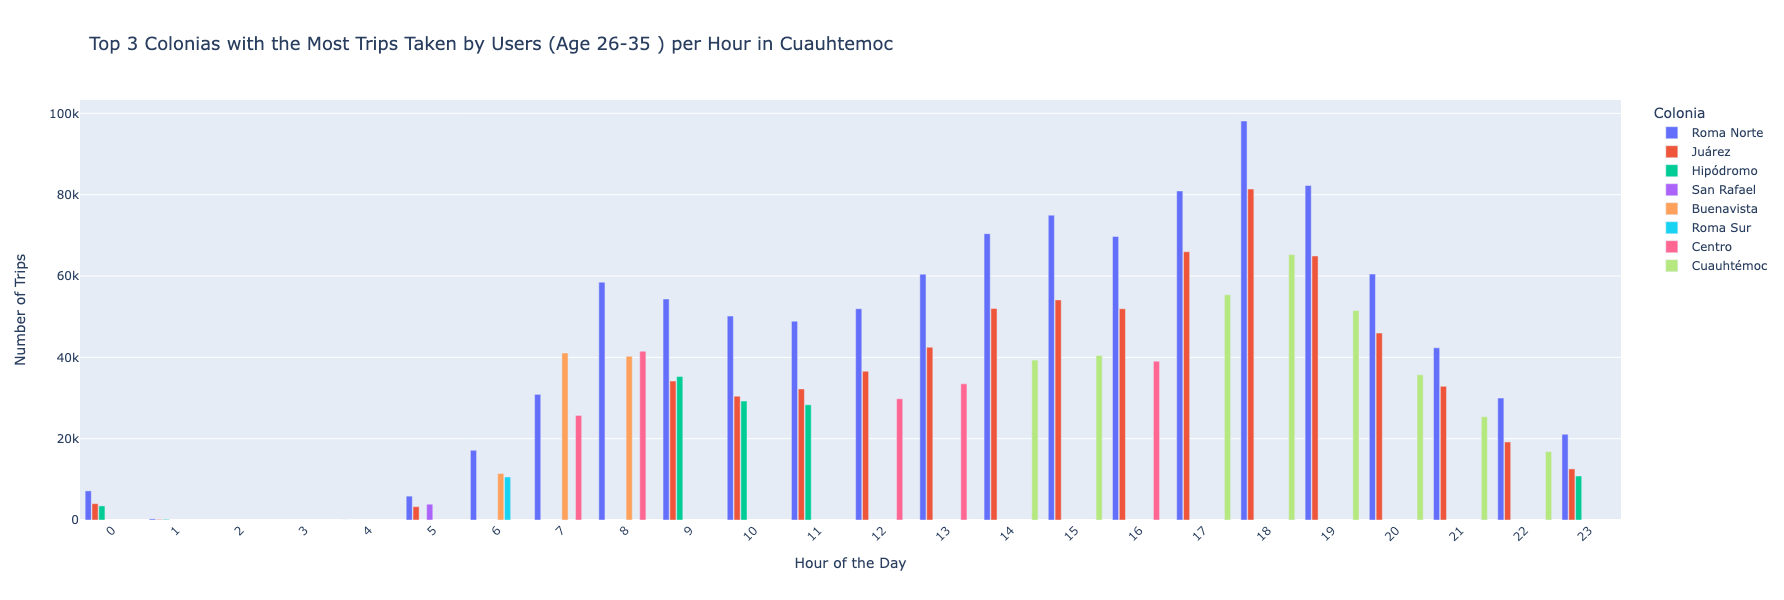

### For age group 26 - 35 again Roma norte is the most popular for trips with juarez in second from 9am - 11am alongside Hipodromo
### Buena vista shows activity starting at 6am - 8am and centro from 7am and 8am
### Centro again shows activity from 12-1pm
### Cuauhtemoc again shows activity starting at 2pm until 11pm 
### peaks for this age group are 8am, 3pm, and 6pm
### this group shows the most trips taken hourly for alcaldia cuauhtemoc

In [ ]:
# Group by 'Hour' and 'Colonia' and count the number of trips
trip_count_per_hour_colonia_age_group = age_group_36_45_data.groupby(['Hour', 'Colonia']).size().reset_index(name='Trip_Count')

# Get the top 3 colonias for each hour by trip count
top_3_colonias_per_hour_age_group = trip_count_per_hour_colonia_age_group.groupby('Hour').apply(lambda x: x.nlargest(3, 'Trip_Count')).reset_index(drop=True)

# Create a bar chart using Plotly
fig = px.bar(top_3_colonias_per_hour_age_group, 
             x='Hour', 
             y='Trip_Count', 
             color='Colonia', 
             title='Top 3 Colonias with the Most Trips Taken by Users (Age 36-45) per Hour in Cuauhtemoc',
             labels={'Hour': 'Hour of the Day', 'Trip_Count': 'Number of Trips', 'Colonia': 'Colonia'},
             barmode='group')

# Customize the layout for better readability
fig.update_layout(
    xaxis_title='Hour of the Day',
    yaxis_title='Number of Trips',
    xaxis_tickangle=-45,
    title_font_size=18,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    height=600,  # Set the height of the chart
    bargap=0.15,  # Adjust the gap between bars for better visualization
    bargroupgap=0.1  # Adjust the gap between groups of bars
)

# Update x-axis ticks to show all hours from 0 to 23
fig.update_xaxes(tickmode='array', tickvals=list(range(24)))

# Show the plot
fig.show()

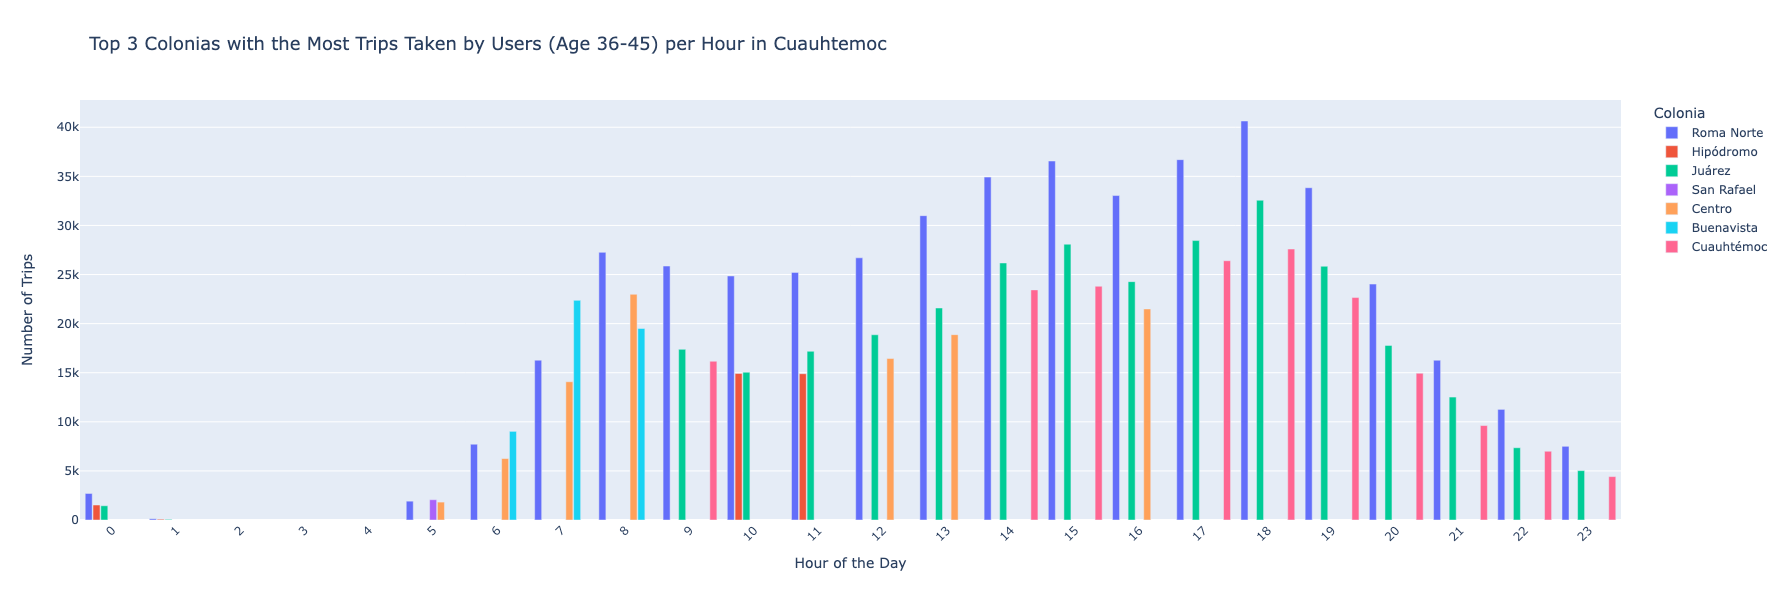

### Age group 36-45 activity show rush hour activity 8am, 3pm and 6pm
### Roma norta records the highest amount of trips taken for this age group for all hours of the day
### Centro and buenavista show earlier activity starting from 6am to 8am
### Juarez shows activity from 9am untill the end of the day
### Cuauhtemoc shows activty from 2pm until the end of the day

In [ ]:
# Group by 'Hour' and 'Colonia' and count the number of trips
trip_count_per_hour_colonia_age_group = age_group_46_60_data.groupby(['Hour', 'Colonia']).size().reset_index(name='Trip_Count')

# Get the top 3 colonias for each hour by trip count
top_3_colonias_per_hour_age_group = trip_count_per_hour_colonia_age_group.groupby('Hour').apply(lambda x: x.nlargest(3, 'Trip_Count')).reset_index(drop=True)

# Create a bar chart using Plotly
fig = px.bar(top_3_colonias_per_hour_age_group, 
             x='Hour', 
             y='Trip_Count', 
             color='Colonia', 
             title='Top 3 Colonias with the Most Trips Taken by Users (Age 46-60) per Hour in Cuauhtemoc',
             labels={'Hour': 'Hour of the Day', 'Trip_Count': 'Number of Trips', 'Colonia': 'Colonia'},
             barmode='group')

# Customize the layout for better readability
fig.update_layout(
    xaxis_title='Hour of the Day',
    yaxis_title='Number of Trips',
    xaxis_tickangle=-45,
    title_font_size=18,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    height=600,  # Set the height of the chart
    bargap=0.15,  # Adjust the gap between bars for better visualization
    bargroupgap=0.1  # Adjust the gap between groups of bars
)

# Update x-axis ticks to show all hours from 0 to 23
fig.update_xaxes(tickmode='array', tickvals=list(range(24)))

# Show the plot
fig.show()

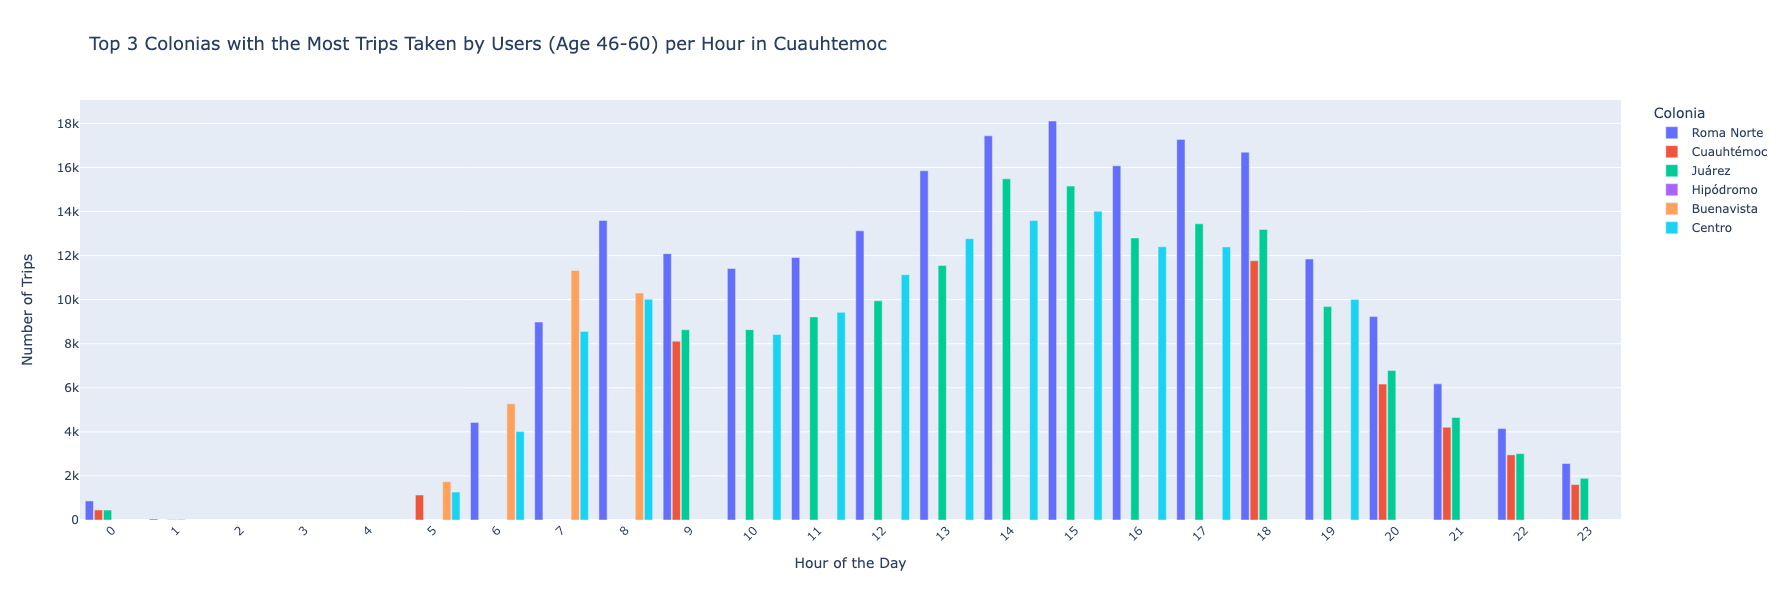

### Age group 46-60 also shows roma norta with the most trips hourly with activity peaking at 8am, 3pm. this group does not show a peak activity at 6pm like the other age groups
### Buena vista and centro show activity starting at 5am until 8am 
### Cuauhtemoc is not a popular colonia throughout the day like other age groups.
### Activity for cuauhtemoc is visible at 8am, 6pm and 20-23:00
### centro and juarez are visible from 10am - 7pm

In [ ]:
# Group by 'Hour' and 'Colonia' and count the number of trips
trip_count_per_hour_colonia_age_group = age_group_61_99_data.groupby(['Hour', 'Colonia']).size().reset_index(name='Trip_Count')

# Get the top 3 colonias for each hour by trip count
top_3_colonias_per_hour_age_group = trip_count_per_hour_colonia_age_group.groupby('Hour').apply(lambda x: x.nlargest(3, 'Trip_Count')).reset_index(drop=True)

# Create a bar chart using Plotly
fig = px.bar(top_3_colonias_per_hour_age_group, 
             x='Hour', 
             y='Trip_Count', 
             color='Colonia', 
             title='Top 3 Colonias with the Most Trips Taken by Users (Age 61-99) per Hour in Cuauhtemoc',
             labels={'Hour': 'Hour of the Day', 'Trip_Count': 'Number of Trips', 'Colonia': 'Colonia'},
             barmode='group')

# Customize the layout for better readability
fig.update_layout(
    xaxis_title='Hour of the Day',
    yaxis_title='Number of Trips',
    xaxis_tickangle=-45,
    title_font_size=18,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    height=600,  # Set the height of the chart
    bargap=0.15,  # Adjust the gap between bars for better visualization
    bargroupgap=0.1  # Adjust the gap between groups of bars
)

# Update x-axis ticks to show all hours from 0 to 23
fig.update_xaxes(tickmode='array', tickvals=list(range(24)))

# Show the plot
fig.show()

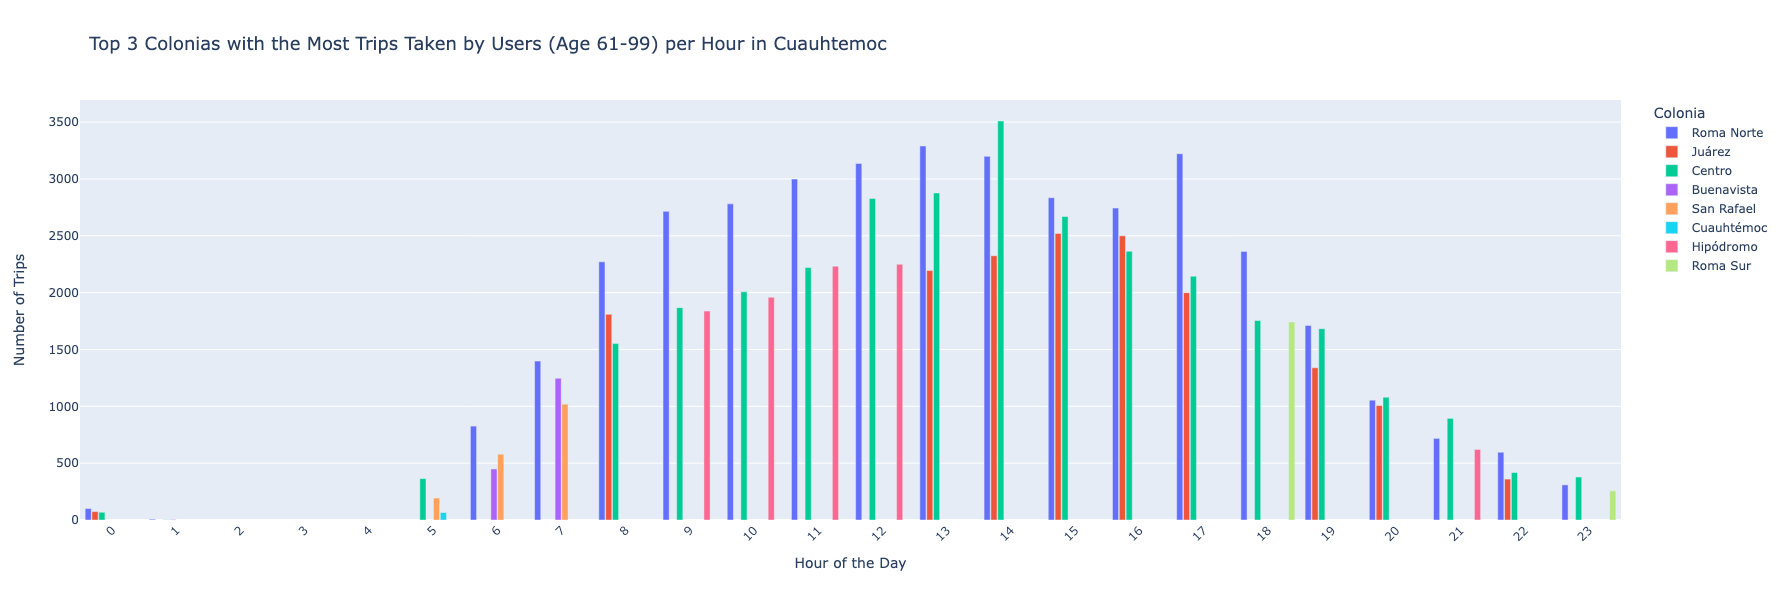

### Age group 61-99 does not follow the rush hour peak activity
### This group begins activity at 5am and increases every hour until 1-2 pm then a drop in trips with a spike at 5pm
### This group is the first to show a higher number of trips taking by Centro over roma norte at 2pm
### Also roma norte does not lead all hours for this group
### From 20-23 the data shows that other colonias lead trips over roma 
### Juarz does not show poplarity from 9am till 12pm
### 1pm till 22 show juarez as 3rd place 
### This age group records the least amount of trip sout of all other age groups

# Summary of Findings

## Colonias with Too Many Stations but Low Usage:

### Centro, Santa María la Ribera, Doctores, and Obrera have excess stations but low engagement.
### Roma leads in trips and stations.
### Cuauhtémoc and Centro, despite being busy, have lower trip durations.
### Safety concerns in Doctores, Obrera, and Centro compared to Roma.

## Trip Duration and Population Insights:

### High trip durations in Cuauhtémoc's top right corner.
### Trip counts are high on busy avenues, influenced by proximity to Polanco.
### January-May are busiest months; June-August see Atlampa leading in trip duration.
### Centro is popular for long trip durations.

## Age Group Insights:

### Roma Norte has the highest trip count for 26-35 age group.
### 16-25 age group leads in Santa María la Ribera and in trip duration in Centro and Cuauhtémoc.
### Each age group leads in specific colonias except 36-45.
### No predominant age group for longer rides except in Centro.

## Gender Insights:

### Males dominate trip counts, but females have higher average trip durations.
### Female usage is high in Atlampa, Roma Norte, Condesa, and Hipódromo.
### Female activity is concentrated in the west of Cuauhtémoc, near Miguel Hidalgo.
## Weekly and Daily Insights:

### Atlampa has the highest percentage of females for average trip duration.
### 16-25 age group leads in trip duration every day.
### Specific age groups lead in different colonias on various days.
### Roma Norte leads in trips hourly, with peak activity in Centro, Juárez, and Hipódromo at specific times.
## Hourly Trends:

### 16-25 age group shows high activity in Roma Norte all hours, with peaks at 8 am, 3 pm, and 6 pm.
### 26-35 and 36-45 age groups show similar patterns, with Roma Norte leading.
### 46-60 age group peaks at 8 am and 3 pm, less at 6 pm.
### 61-99 age group shows early activity, peaking at 1-2 pm and 5 pm.
### Recommendations
## Optimize Station Placement:

### Relocate/reduce stations in low-usage areas (Doctores, Obrera).
### Increase stations in high-demand areas (Roma, Cuauhtémoc).
## Enhance Safety and Bike-Friendliness:

### Improve bike lanes and safety in Doctores, Obrera.
### Promote bike-friendly initiatives in these areas.
## Targeted Promotions and Campaigns:

### Promote biking during peak months (January-May) with special offers/events.
### Encourage summer biking (June-August) with heat management solutions.
## Age-Specific Strategies:

### Tailor campaigns for 26-35 age group in Roma Norte.
### Engage 16-25 age group in Santa María la Ribera with events/social rides.
### Maintain interest of 16-25 age group in Centro and Cuauhtémoc.
## Gender Inclusivity:

### Promote biking among females, emphasizing safety and convenience.
### Implement female-centric events in Atlampa, Roma Norte, Condesa.
### Ensure bike infrastructure improvements consider female riders.
## Hourly and Weekly Engagement:

### Promote bike usage during peak hours (8 am, 3 pm, 6 pm) with discounts/incentives.
### Organize events during peak hours for visibility/engagement.
### Provide tailored services for different age groups during peak times.
## Collaboration with Nearby Alcaldias:

### Collaborate with Miguel Hidalgo, especially near Polanco, for seamless routes and joint promotions.